In [3]:
from pydap.client import open_url
from datetime import datetime
import numpy as np
import pandas as pd
import time
from datetime import timedelta
import pyproj
import xarray as xr
from scipy.interpolate import LinearNDInterpolator
import matplotlib.pyplot as plt
import math
import pickle
from datetime import date
import os
import plotly.express as px
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib
import cartopy as cart


def retrieve_microplastics_gt():
    lats = np.zeros(181)
    count = 90
    for i in range(len(lats)):
        lats[i] = count
        count -= 1
    for filename in os.listdir('../microplast_gt'):
        logfilename = filename[:-4] + '_log'
        try:
            df = pd.read_csv('../microplast_gt/' + filename, header=None)

        except:
            print(filename)
            continue
        longlist = []
        latlist = []
        valuelist_log = []
        valuelist = []
        for long in range(0, 361):
            for lat in range(0, 181):
                val = df[long][lat]
                if val < 1:
                    valuelist_log.append(np.nan)
                else:
                    valuelist_log.append(np.log10(val))
                longlist.append(long)
                latlist.append(lats[lat])
                valuelist.append(val)
        if filename == "lebretonmodel_abundance.csv":
            res_df = pd.DataFrame(
                {'sp_lon': longlist, 'sp_lat': latlist, filename[:-4]: valuelist, logfilename: valuelist_log})
        else:
            res_df[filename[:-4]] = valuelist
            res_df[logfilename] = valuelist_log
    return res_df


def plot_var_2(df, var):
    # Settings for the plot
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    ax.add_feature(cart.feature.LAND, zorder=100, edgecolor='k')
    ax.gridlines(draw_labels=True, alpha=0.5)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    plt.scatter(df['sp_lon'], df['sp_lat'], c=list(df[var]))
    bar = plt.colorbar(pad=0.15, orientation='horizontal')
    plt.title(var)
    ax.add_patch(matplotlib.patches.Rectangle(xy=[220, -40], width=40, height=20,
                                    alpha=1,
                                    color = 'red',
                                    fill = None,
                                    transform=ccrs.PlateCarree())
                 )
    ax.add_patch(matplotlib.patches.Rectangle(xy=[220, 20], width=40, height=20,
                                alpha=1,
                                color = 'red',
                                fill = None,
                                transform=ccrs.PlateCarree())
             )
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.savefig('region.png')
    plt.show()


def plot_var(df, var):
    # Settings for the plot
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    ax.add_feature(cart.feature.LAND, zorder=100, edgecolor='k')
    ax.gridlines(draw_labels=True, alpha=0.5)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    plt.scatter(df['lon'], df['lat'], c=list(df[var]))
    bar = plt.colorbar(pad=0.15, orientation='horizontal')
    plt.title(var)
    bar.ax.set_title('Power 10^')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.savefig('nbrcs-diff.svg')
    plt.show()

# SET AREA, Function Is called when extracting CYGNSS, OSKAR and ERA5
def reduce_area_of_df(df):
    df = df[df.sp_lat <= 40]
    df = df[df.sp_lat >= -40]

    df_northern = df[df.sp_lat >= 20]
    df_southern = df[df.sp_lat <= -20]
    df = pd.concat([df_northern, df_southern])
    df = df[df.sp_lon >= 220]
    return df[df.sp_lon <= 260]


# SET AREA, Function Is called when extracting CYGNSS, OSKAR and ERA5
def reduce_area_of_df(df):
    df = df[df.sp_lat <= 40]
    df = df[df.sp_lat >= -40]

    df_northern = df[df.sp_lat >= 20]
    df_southern = df[df.sp_lat <= -20]
    df = pd.concat([df_northern, df_southern])
    df = df[df.sp_lon >= 220]
    return df[df.sp_lon <= 260]

def open_anomalies_csvs():
    df_list = []
    for filename in os.listdir('../test_mss'):
        df_list.append(pd.read_csv('../test_mss/' + filename))
    if len(df_list) == 1:
        return df_list[0]
    else:
        return pd.concat(df_list)


In [4]:
mic_df = retrieve_microplastics_gt().dropna()
interp_micro_mass = LinearNDInterpolator(list(zip(mic_df['sp_lon'], mic_df['sp_lat'])), mic_df['vansebillemodel_mass_log'])
interp_micro_abu = LinearNDInterpolator(list(zip(mic_df['sp_lon'], mic_df['sp_lat'])), mic_df['vansebillemodel_abundance_log'])

.ipynb_checkpoints


In [85]:
df = open_anomalies_csvs()
df['delta'] = np.sqrt((df.wind_u10-df.current_u)**2 + (df.wind_v10-df.current_v)**2)
df['total_wind'] = np.sqrt((df.wind_u10)**2 + (df.wind_v10)**2)
df['micro_mass'] = interp_micro_mass(df['lon'], df['lat'])
df['abundace'] = interp_micro_abu(df['lon'], df['lat'])
df = df.dropna()
df['mss_anomaly'] = (df.mss_cygnss-df.mss_wind_current)/df.mss_wind_current
df = df[df.total_wind <= 10]
df

,lon,lat,mss_cygnss,mss_wind_current,mss_towards_wind,mss_towards_delta,nbrcs,wind_u10,wind_v10,current_u,current_v,biases,fresnel,delta,total_wind,micro_mass,abundace,mss_anomaly
0,223.735321,-37.047737,0.005708,0.013089,0.028759,0.028677,18.926369,2.764832,-6.344178,0.113535,0.018903,-0.160000,0.667662,6.893342,6.920469,1.726264,4.082472,-0.563918
56,220.271622,-37.130970,0.012090,0.016585,0.033049,0.032837,15.670807,4.132686,-7.414802,0.082614,-0.051684,-0.168073,0.667951,8.403487,8.488721,1.776191,4.132400,-0.271038
57,220.305328,-37.135284,0.010202,0.016570,0.033016,0.032819,16.407864,4.129028,-7.401663,0.082253,-0.044774,-0.169876,0.667937,8.396440,8.475464,1.781018,4.137227,-0.384299
58,220.339035,-37.139599,0.011889,0.016554,0.032983,0.032801,15.743156,4.125371,-7.388523,0.082306,-0.037859,-0.170000,0.667923,8.389198,8.462208,1.785846,4.142054,-0.281837
59,220.406433,-37.148170,0.010860,0.016554,0.032948,0.032801,16.136031,4.119101,-7.376098,0.083516,-0.021342,-0.170000,0.667895,8.389182,8.448302,1.795516,4.151724,-0.344006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343,259.213196,-38.706463,0.001596,0.004547,0.013407,0.013149,22.961493,3.109795,0.798567,0.064431,0.045935,2.225892,0.561880,3.136988,3.210690,1.109008,3.465215,-0.648921
344,259.459412,-38.621941,0.001687,0.004264,0.012428,0.012178,22.735105,2.660646,1.228881,0.049760,0.062816,2.285280,0.562737,2.859446,2.930731,1.179647,3.535857,-0.604416
345,259.613098,-38.568874,0.002255,0.004123,0.011820,0.011571,21.482422,2.349031,1.443492,0.038173,0.074526,2.309074,0.563271,2.685913,2.757103,1.243842,3.600054,-0.452946
347,256.371338,-38.428036,0.000690,0.008004,0.021501,0.021684,27.483630,4.778730,-1.075018,-0.025447,0.079552,0.783917,0.621592,4.940966,4.898155,1.228395,3.584601,-0.913830


In [86]:
top_frac = 0.064 * df['total_wind'] ** 3 - 0.214 * df['total_wind'] ** 2 + 1.216 ** df['total_wind'] + 1.105
bot_frac = df['total_wind'] ** 3 + 18.180 * df['total_wind'] ** 2 - 117.600 * df['total_wind'] + 706.9
mss_from_kotsberg = top_frac / bot_frac
df['mss_from_kotsberg'] = mss_from_kotsberg
df['mss_towards_wind'] = df['mss_towards_wind']*0.40
df['mss_anomaly'] = (df.mss_cygnss-df.mss_towards_wind)/df.mss_towards_wind

In [87]:
df = df[df.mss_anomaly < 1]
df = df[df.mss_anomaly > -1]
df = df[df.total_wind <= 10]
df = df[df.abundace >= 3.6]
fig = px.density_heatmap(df, y="abundace", x="mss_anomaly", nbinsx = 100, nbinsy = 100, color_continuous_scale=px.colors.sequential.Blackbody)
fig.show()

In [76]:
bin_df = pd.DataFrame({'mss':df.mss_anomaly, 'micro' : df.abundace })
cut = pd.cut(bin_df['mss'], bins = np.linspace(bin_df.mss.min(), bin_df.mss.max(), 100)).cat.codes
bin_df['mss_bins'] = cut
cut = pd.cut(bin_df['mss'], bins = np.linspace(bin_df.mss.min(), bin_df.mss.max(), 100))
bin_df['mss_bins_ranges'] = cut
bin_df = bin_df[bin_df.mss_bins == 40]
bin_df

,mss,micro,mss_bins,mss_bins_ranges
141,-0.171532,3.951582,40,"(-0.176, -0.157]"
293,-0.163251,3.905460,40,"(-0.176, -0.157]"
1201,-0.160249,4.017501,40,"(-0.176, -0.157]"
1578,-0.172273,3.710746,40,"(-0.176, -0.157]"
1582,-0.159827,3.777632,40,"(-0.176, -0.157]"
...,...,...,...,...
38302,-0.173293,4.262275,40,"(-0.176, -0.157]"
38304,-0.166435,4.252087,40,"(-0.176, -0.157]"
38503,-0.172994,3.894752,40,"(-0.176, -0.157]"
38511,-0.163910,3.767665,40,"(-0.176, -0.157]"


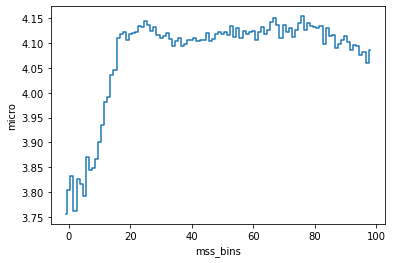

In [70]:
mean_micro_by_bin = bin_df.groupby(['mss_bins'], as_index=False)['micro'].mean()
#mean_micro_by_bin = mean_micro_by_bin[mean_micro_by_bin.mss_bins > 25]
#mean_micro_by_bin = mean_micro_by_bin[mean_micro_by_bin.mss_bins < 50]
mean_micro_by_bin
plt.step(
    mean_micro_by_bin['mss_bins'],
    mean_micro_by_bin['micro'],
    where='mid',
)
plt.xlabel('mss_bins')
plt.ylabel('micro')
plt.show()

In [79]:
df['mss_cygnss'].mean(), df['mss_towards_wind'].mean(), df['mss_towards_delta'].mean(), df['mss_wind_current'].mean(), df['mss_from_kotsberg'].mean()

(0.00879412385705694,
 0.02474897043882439,
 0.024698482659492565,
 0.01131109149556109,
 0.012548130647107735)